## Анализ вакансий сайта hh.ru

## Подготовка данных

In [50]:
#%pip install pandas
#%pip install numpy
import sqlite3
import pandas as pd
import numpy as np

con = sqlite3.connect("..\db\hhvacancy.db")
cur = con.cursor()
vacancies_frame = pd.read_sql("SELECT * FROM VacancyFullInfo", con)

In [51]:
vacancies_frame

,VacancyId,VacancyName,AreaName,EmployerName,HasTest,PublishedAt,ResponseLetterRequired,SalaryCurrency,SalaryFrom,SalaryTo,...,ExperienceName,CountersResponses,CountersTotalResponses,HigherEducationMention,SalaryFromClear,SalaryToClear,SalaryMiddleClear,VacancyDescription,KeySkills,ProfessionalRoles
0,101020118,Middle/Senior iOS разработчик,Новосибирск,FullStack,0,2024-06-15 01:27:40,0,RUR,120000.0,250000.0,...,От 3 до 6 лет,55,55,0,120000.0,250000.0,185000.0,<p>Требуется iOS разработчик для работы над пр...,None,"Программист, разработчик"
1,101019344,Junior iOS разработчик,Новосибирск,FullStack,0,2024-06-15 01:16:57,0,RUR,70000.0,120000.0,...,От 1 года до 3 лет,144,144,0,70000.0,120000.0,95000.0,<p>Требуется iOS разработчик для работы над пр...,None,"Программист, разработчик"
2,100426572,PHP / Laravel Developer (Удаленно),Москва,KingBoost,0,2024-06-15 00:35:01,1,USD,2000.0,3000.0,...,От 3 до 6 лет,137,137,0,2000.0,3000.0,2500.0,<p><strong>KingBoost — это огромный сервис вну...,"Laravel,PHP","Программист, разработчик"
3,100426573,PHP / Laravel Developer (Удаленно),Санкт-Петербург,KingBoost,0,2024-06-15 00:35:01,1,USD,2000.0,3000.0,...,От 3 до 6 лет,102,102,0,2000.0,3000.0,2500.0,<p><strong>KingBoost — это огромный сервис вну...,"Laravel,PHP","Программист, разработчик"
4,100426574,PHP / Laravel Developer (Удаленно),Минск,KingBoost,0,2024-06-15 00:35:01,1,USD,2000.0,3000.0,...,От 3 до 6 лет,118,118,0,2000.0,3000.0,2500.0,<p><strong>KingBoost — это огромный сервис вну...,"Laravel,PHP","Программист, разработчик"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2377,99124707,Сетевой инженер (NetOps),Ижевск,ЭДС,0,2024-05-16 09:55:36,0,RUR,80000.0,100000.0,...,От 3 до 6 лет,10,10,0,80000.0,100000.0,90000.0,"<p>Современная и высокотехнологичная компания,...","BGP,L2/L3-коммутация,Linux,Настройка сетевых п...",Сетевой инженер
2378,92438637,QA Automation Engineer Python (MCPTT),Санкт-Петербург,"Протей, НТЦ",0,2024-05-16 09:41:41,0,RUR,150000.0,NaN,...,От 3 до 6 лет,73,167,0,150000.0,NaN,75000.0,<div><strong>ПРОТЕЙ </strong><em>— </em>группа...,"CI/CD,Docker,HTTP,IMS,Linux,PyTest,Python,SIP,...",Тестировщик
2379,97085350,"QA инженер (JS, TS, Selenium)",Москва,Data World,0,2024-05-16 09:32:37,0,RUR,200000.0,210000.0,...,От 1 года до 3 лет,56,228,0,174000.0,182700.0,178350.0,<p><strong>Работа из офиса банка на время прох...,Автотестирование интерфейсов,Тестировщик
2380,99118520,QA-инженер,Нижний Новгород,Фланг,0,2024-05-16 09:14:16,0,RUR,50000.0,90000.0,...,От 1 года до 3 лет,144,144,0,50000.0,90000.0,70000.0,"<p>Привет! В связи с расширением штата, открыт...",None,Тестировщик


### Конвертация валюты заработной платы в рубли

In [52]:
#%pip install requests

In [53]:
# %load wallet_converter
import requests
from xml.etree import ElementTree as ET

def get_exchange_rates(date):
    url = f'https://www.cbr.ru/scripts/XML_daily.asp?date_req={date}'
    response = requests.get(url)
    response.raise_for_status()  # Проверка успешности запроса
    return response.content

def parse_exchange_rates(xml_data):
    tree = ET.ElementTree(ET.fromstring(xml_data))
    root = tree.getroot()
    
    rates = {}
    for currency in root.findall('Valute'):
        char_code = currency.find('CharCode').text
        value = float(currency.find('Value').text.replace(',', '.'))
        nominal = float(currency.find('Nominal').text.replace(',', '.'))
        rates[char_code] = value / nominal
        
    rates['BYR'] = rates['BYN']
    return rates

def convert_currency_internal(amount, from_currency, to_currency, rates):

    if from_currency == 'RUR':
        from_currency = 'RUB'

    if to_currency == 'RUR':
        to_currency = 'RUB'    

    if from_currency != 'RUB':
        amount = amount * rates[from_currency]

    if to_currency != 'RUB':
        amount = amount / rates[to_currency]

    return amount


date = '16/06/2024'  # Дата в формате ДД/ММ/ГГГГ


xml_data = get_exchange_rates(date)
rates = parse_exchange_rates(xml_data)


def convert_currency(amount, from_currency, to_currency):
    return convert_currency_internal(amount, from_currency, to_currency, rates)



In [54]:
convert_currency(100, 'RUR', 'RUB')

100

In [55]:
vacancies_frame["SalaryMiddleRub"] = vacancies_frame.apply(lambda row: convert_currency(row['SalaryMiddleClear'], row['SalaryCurrency'], 'RUB'), axis=1)

### Информация о наборе данных

In [56]:
vacancies_frame.head(10)

,VacancyId,VacancyName,AreaName,EmployerName,HasTest,PublishedAt,ResponseLetterRequired,SalaryCurrency,SalaryFrom,SalaryTo,...,CountersResponses,CountersTotalResponses,HigherEducationMention,SalaryFromClear,SalaryToClear,SalaryMiddleClear,VacancyDescription,KeySkills,ProfessionalRoles,SalaryMiddleRub
0,101020118,Middle/Senior iOS разработчик,Новосибирск,FullStack,0,2024-06-15 01:27:40,0,RUR,120000.0,250000.0,...,55,55,0,120000.0,250000.0,185000.0,<p>Требуется iOS разработчик для работы над пр...,None,"Программист, разработчик",185000.00
1,101019344,Junior iOS разработчик,Новосибирск,FullStack,0,2024-06-15 01:16:57,0,RUR,70000.0,120000.0,...,144,144,0,70000.0,120000.0,95000.0,<p>Требуется iOS разработчик для работы над пр...,None,"Программист, разработчик",95000.00
2,100426572,PHP / Laravel Developer (Удаленно),Москва,KingBoost,0,2024-06-15 00:35:01,1,USD,2000.0,3000.0,...,137,137,0,2000.0,3000.0,2500.0,<p><strong>KingBoost — это огромный сервис вну...,"Laravel,PHP","Программист, разработчик",222664.50
3,100426573,PHP / Laravel Developer (Удаленно),Санкт-Петербург,KingBoost,0,2024-06-15 00:35:01,1,USD,2000.0,3000.0,...,102,102,0,2000.0,3000.0,2500.0,<p><strong>KingBoost — это огромный сервис вну...,"Laravel,PHP","Программист, разработчик",222664.50
4,100426574,PHP / Laravel Developer (Удаленно),Минск,KingBoost,0,2024-06-15 00:35:01,1,USD,2000.0,3000.0,...,118,118,0,2000.0,3000.0,2500.0,<p><strong>KingBoost — это огромный сервис вну...,"Laravel,PHP","Программист, разработчик",222664.50
5,101973719,Fullstack PHP Developer (SalesRep.ai),Москва,Americor Funding Inc,1,2024-06-15 00:27:39,0,USD,3500.0,4500.0,...,0,0,0,3500.0,4500.0,4000.0,<p>С 2017 года <strong>Americor </strong>помог...,"MySQL,PHP,Python","Программист, разработчик",356263.20
6,101972784,Senior Golang программист,Санкт-Петербург,MartLive Inc.,0,2024-06-14 23:36:21,0,RUR,200000.0,300000.0,...,0,0,0,200000.0,300000.0,250000.0,<p>Чем предстоит заниматься:</p> <p>Решать как...,"Docker,Go,Golang,gRPC,MongoDB,NATS,Nomad,Redis","Программист, разработчик",250000.00
7,86258755,Middle/Senior SRE инженер,Москва,Биг Дата Технолоджи,0,2024-06-14 23:23:32,0,RUR,275000.0,375000.0,...,21,400,0,275000.0,375000.0,325000.0,<p><strong>Биг Дата Технолоджи </strong>- комп...,"Ansible,Clickhouse,DevOps,Docker,ELK,Gitlab,Gr...",Системный администратор,325000.00
8,95846246,Go-разработчик,Москва,Фабрика Решений,0,2024-06-14 22:59:57,0,RUR,100000.0,270000.0,...,86,511,0,100000.0,270000.0,185000.0,<p>Привет! Мы – студия fabrique и мы автоматиз...,"Beta-тестирования,MS Access,ООП,PostgreSQL,Rab...","Программист, разработчик",185000.00
9,99434903,Мобильный разработчик iOS,Краснодар,Гладунова Евгения Сергеевна,0,2024-06-14 22:58:27,0,USD,2000.0,3500.0,...,212,212,0,2000.0,3500.0,2750.0,<p>Требуется <strong>разработчик с опытом </st...,"iOS,Objective-C,Swift,webview,Xcode","Программист, разработчик",244930.95


In [57]:
vacancies_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 0 to 2381
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   VacancyId               2382 non-null   object 
 1   VacancyName             2382 non-null   object 
 2   AreaName                2382 non-null   object 
 3   EmployerName            2381 non-null   object 
 4   HasTest                 2382 non-null   int64  
 5   PublishedAt             2382 non-null   object 
 6   ResponseLetterRequired  2382 non-null   int64  
 7   SalaryCurrency          2382 non-null   object 
 8   SalaryFrom              2034 non-null   float64
 9   SalaryTo                1426 non-null   float64
 10  SalaryGross             2382 non-null   int64  
 11  SnippetRequirement      2343 non-null   object 
 12  SnippetResponsibility   2332 non-null   object 
 13  VacancyTypeName         0 non-null      object 
 14  Url                     2382 non-null   

### Описательные статистики

In [58]:
vacancies_frame.describe(include='all')

,VacancyId,VacancyName,AreaName,EmployerName,HasTest,PublishedAt,ResponseLetterRequired,SalaryCurrency,SalaryFrom,SalaryTo,...,CountersResponses,CountersTotalResponses,HigherEducationMention,SalaryFromClear,SalaryToClear,SalaryMiddleClear,VacancyDescription,KeySkills,ProfessionalRoles,SalaryMiddleRub
count,2382,2382,2382,2381,2382.000000,2382,2382.000000,2382,2.034000e+03,1.426000e+03,...,2382.000000,2382.000000,2382.000000,2.034000e+03,1.426000e+03,2.382000e+03,2382,1577,2382,2382.000000
unique,2382,1311,207,1552,NaN,2141,NaN,7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2102,1370,56,NaN
top,101020118,Специалист по информационной безопасности,Москва,"Алабуга, ОЭЗ ППТ",NaN,2024-06-11 07:20:00,NaN,RUR,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,<strong>Обязанности:</strong> <ul> <li>Разрабо...,"1С программирование,Проведение тестирований","Программист, разработчик",NaN
freq,1,147,864,45,NaN,32,NaN,2180,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,32,10,572,NaN
mean,NaN,NaN,NaN,NaN,0.030647,NaN,0.018472,NaN,1.762227e+05,2.864200e+05,...,59.036524,109.100756,0.036104,1.704979e+05,2.740106e+05,1.548135e+05,NaN,NaN,NaN,107371.991140
std,NaN,NaN,NaN,NaN,0.172394,NaN,0.134678,NaN,7.388549e+05,1.417793e+06,...,141.671601,281.348766,0.186588,7.309789e+05,1.361933e+06,8.125880e+05,NaN,NaN,NaN,86418.119122
min,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,1.400000e+02,1.900000e+02,...,0.000000,0.000000,0.000000,1.400000e+02,1.900000e+02,1.650000e+02,NaN,NaN,NaN,165.000000
25%,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,6.000000e+04,8.000000e+04,...,2.000000,7.000000,0.000000,5.744000e+04,7.847500e+04,4.227125e+04,NaN,NaN,NaN,50000.000000
50%,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,1.000000e+05,1.500000e+05,...,9.000000,26.000000,0.000000,1.000000e+05,1.479000e+05,7.500000e+04,NaN,NaN,NaN,80000.000000
75%,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,1.700000e+05,2.500000e+05,...,46.000000,97.750000,0.000000,1.652250e+05,2.400000e+05,1.305000e+05,NaN,NaN,NaN,140000.000000


## Конфигурация отрисовки графиков

In [59]:
#%pip install matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline


### Гистограмма откликов по вакансиям

<Axes: >

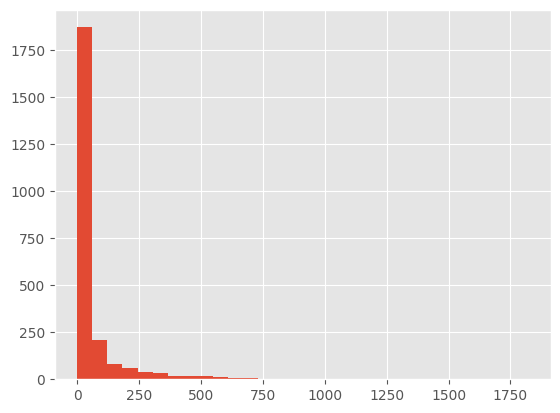

In [60]:
vacancies_frame["CountersResponses"].hist(bins=30)

### Гистограмма по средним зарплатам

<Axes: >

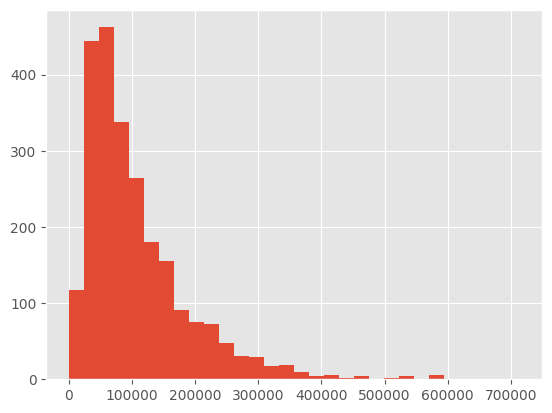

In [61]:
vacancies_frame["SalaryMiddleRub"].hist(bins=30)